# HW03: Distance and Topic Model

Remember that these homework work as a completion grade. **You can skip one section without losing credit.**

## Load and Pre-process Text

In [2]:
#Import the AG news dataset (same as hw01)
#Download them from here 
#!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv

import pandas as pd
import nltk
df = pd.read_csv('train.csv')

df.columns = ["label", "title", "lead"]
label_map = {1:"world", 2:"sport", 3:"business", 4:"sci/tech"}
def replace_label(x):
	return label_map[x]
df["label"] = df["label"].apply(replace_label) 
df["text"] = df["title"] + " " + df["lead"]
df.head()

--2023-03-16 12:40:26--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29470338 (28M) [text/plain]
Saving to: ‘train.csv.1’

train.csv.1         100%[===================>]  28.10M   137MB/s    in 0.2s    

2023-03-16 12:40:26 (137 MB/s) - ‘train.csv.1’ saved [29470338/29470338]



,label,title,lead,text
0,business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
1,business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
2,business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
3,business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."
4,business,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...,"Stocks End Up, But Near Year Lows (Reuters) Re..."


In [7]:
import spacy
dfs = df.sample(200)
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.utils import simple_preprocess

##TODO pre-process text as you did in HW02

dfs["prepro"] = dfs["text"].apply(lambda x : ' '.join( simple_preprocess(x)))

##TODO vectorize the pre-processed text using TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=0.01, 
                        max_df=0.9,  
                        max_features=1000,
                        stop_words='english',
                        use_idf=True, # the new piece
                        ngram_range=(1,2))

vectorized = vectorizer.fit_transform(dfs["prepro"])


## Cosine Similarity and PCA

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
##TODO compute the cosine similarity for the first 200 snippets and for the first snippet, show the three most similar snippets and their respective cosine similarity scores

data = list()

for i,vector in enumerate(vectorized[0:200]):
    data.append((i,cosine_similarity(vectorized[0], vector)))

data.sort(key=lambda x: x[1], reverse=True)
for i in range(1,4):
    print("Snippet: ", dfs.iloc[data[i][0]]["text"])
    print("Cosine similarity: ", data[i][1])
    print("")


Snippet:  After Long Hiatus, Iraqi Airways Back in Skies The Boeing 737 banked sharply to the left as it roared into the sky from Baghdad International Airport. The pilot, Adel Aldoori, cupped his hand to block the sun and scanned the ground from the tiny cockpit window.
Cosine similarity:  [[0.23985626]]

Snippet:  Boeing and Airbus clash The US and the EU have agreed to hold further talks in order to avoid legal action in the trade dispute over government support for Airbus and Boeing.
Cosine similarity:  [[0.23109594]]

Snippet:  Boeing downplays jet market upturn forecasts by Airbus NEW YORK, September 24 (newratings.com) - Boeing Company #39;s (BA.NYS) Chief Executive Officer, Harry Stonecipher, said today that the European aircraft manufacturer, Airbus, was exaggerating the pace of the recovery in the commercial jet market.
Cosine similarity:  [[0.17787999]]



In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')

##TODO reduce the vectorized data using PCA
##TODO compute again cosine similarity with the reduced version for the first 200 snippets
##TODO for the first snippet, show again its three most similar snippets

vectorized_reduced = pca.fit_transform(vectorized.toarray())
similarities = cosine_similarity(vectorized_reduced)
similar = similarities[0].argsort()[-4:][::-1]

for i in similar[1:]:
    print("Snippet: ", dfs.iloc[i]["text"])
    print("Cosine similarity: ", similarities[0][i])
    print("")


Snippet:  Russia to Help Train South Korean Astronaut by 2007 (Reuters) Reuters - Russia agreed on Tuesday to help train\South Korea's first astronaut by 2007 -- although it is still\not clear whether Seoul's space cadet will make it into orbit\that year.
Cosine similarity:  0.9989063129869373

Snippet:  Salesforce.com adds customer support product Hoping to find the same success in the contact center as it found with the sales force, Salesforce.com today added Supportforce.com to its application arsenal.
Cosine similarity:  0.9952373010898207

Snippet:  Boeing downplays jet market upturn forecasts by Airbus NEW YORK, September 24 (newratings.com) - Boeing Company #39;s (BA.NYS) Chief Executive Officer, Harry Stonecipher, said today that the European aircraft manufacturer, Airbus, was exaggerating the pace of the recovery in the commercial jet market.
Cosine similarity:  0.9897509076952681



Compare the cosine similarity before and after PCA reduction. Did the results change? 

## Clustering

In [44]:
#!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

##TODO create the clusters found with k-medoids clustering nd 5 clusters
##TODO create the clusters found with k-means clustering nd 5 clusters

kmedoids = KMedoids(n_clusters=5, random_state=0).fit(vectorized.toarray())
kmeans = KMeans(n_clusters=5, random_state=0).fit(vectorized.toarray())

/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


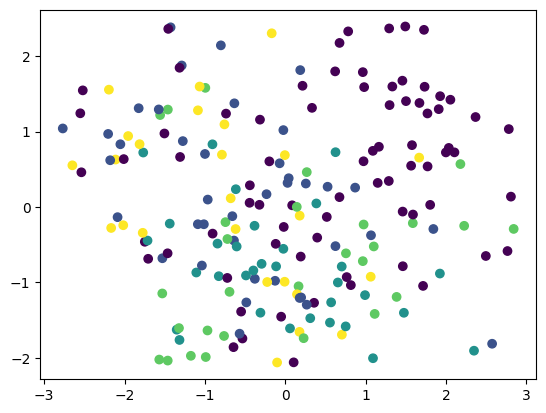

In [46]:
##TODO visualize the k-medoids clustering results through Isomap (first reduce the dimensionality to 2 using Isomap, then use scatter plot (plt.scatter()) to visualize)

from sklearn.manifold import Isomap
import matplotlib.pyplot as plt

isomap = Isomap(n_components=2)
kmedoids_reduced = isomap.fit_transform(vectorized.toarray())

plt.scatter(kmedoids_reduced[:,0], kmedoids_reduced[:,1], c=kmedoids.labels_)

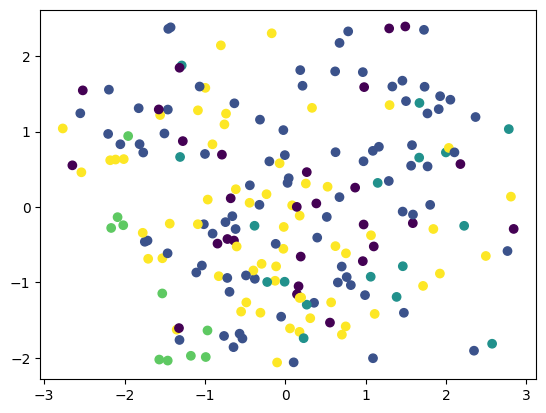

In [47]:
##TODO similarly, visualize the k-means results
isomap = Isomap(n_components=2)
kmeans_reduced = isomap.fit_transform(vectorized.toarray())

plt.scatter(kmeans_reduced[:,0], kmeans_reduced[:,1], c=kmeans.labels_)

## Topic Modeling: LDA

For this part you will need to use LDA Mallet. If you cannot have Mallet run, you can use the simple LDA algorithm 

In [52]:
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel

##TODO create a dictionary with the pre-processed tokenized text and filter it according to frequencies and keeping 1000 vocabularies
##TODO create the doc_term_matrix

# Problem with installind gensim.modesl.wrappers on github workspace...

dictionary = Dictionary(dfs["prepro"].apply(lambda x : x.split()))
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
doc_term_matrix = [dictionary.doc2bow(doc.split()) for doc in dfs["prepro"]]


ModuleNotFoundError: No module named 'gensim.models.wrappers'

In [53]:
# pip install gensim==3.8.3

  Using cached gensim-3.8.3.tar.gz (23.4 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [1253 lines of output]
      /home/codespace/.local/lib/python3.10/site-packages/setuptools/__init__.py:85: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated. Requirements should be satisfied by a PEP 517 installer. If you are using pip, you can try `pip install --use-pep517`.
        dist.fetch_build_eggs(dist.setup_requires)
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-310
      creating build/lib.linux-x86_64-cpython-310/gensim
      copying gensim/downloader.py -> build/lib.linux-x86_64-cpython-310/gensim
      copying gensim/matutils.py -> build/lib.linux-x86_64-cpython-310/gensim
      copying gensim/__init__.py -> build/lib.linux-x86_64-cpython-310/gensim
 

Bad pipe message: %s [b"[w\xc4J8\x08\xae+iJ\xfaD\x04z'\x8f\x91j z\xc8;\xe1\xe8\xd4\x01`x\xf6X\xb5:E\xafU\x99:`>\xf7x\x9f\xb2\xad\x1ci\xde\x83kX\x08\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00"]
Bad pipe message: %s [b'\xe5\x99K1\x07\x9c>{\xdc1\x89\xeb\x93\xf3\xe0{y\xe4 A\x05F\xc1\x10!p\x048"T\xa4\xf9?iv\xba!']
Bad pipe message: %s [b'n\x1b_\x03]\xeb\x13\xbb9g\xc0\x12\x80\x07\x0c\x05\xe3<\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0', b"\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00

In [49]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2023-03-16 13:07:03--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2023-03-16 13:07:04--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  13.2MB/s    in 1.2s    

2023-03-16 13:07:06 (13.2 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [31]:
##TODO train a LDA Mallet model with 5, 10 and 15 topics
##TODO compute the coherence score for each of these model and print the topics from the model with highest coherence score. Then find the opitimal number of topics using the coherence score.

In [32]:
#!pip install pyLDAvis
import pyLDAvis.gensim
from gensim.models import wrappers
##TODO using LDAvis visualize the topics using the optimal number of topics